# CONCEPT DRIFT DETECTION USING GAN

## Pre-processing and initial data analysis

### Data pre-processing

In [4]:
import pandas as pd

# Load the dataset
data = pd.read_excel("Tb disease symptoms.xlsx")

# Select relevant columns
data = data[['date', 'sputum mixed with blood']]

# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

In [5]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Drop rows with missing values
data.dropna(inplace=True)

# Check for and remove duplicates
data.drop_duplicates(inplace=True)

Missing Values:
date                       0
sputum mixed with blood    0
dtype: int64


In [6]:
# Summary statistics of the 'sputum mixed with blood' column
summary_stats = data['sputum mixed with blood'].describe()

# Output the summary statistics
print(summary_stats)

count    552.000000
mean       0.518116
std        0.500125
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sputum mixed with blood, dtype: float64


### Initial data analysis

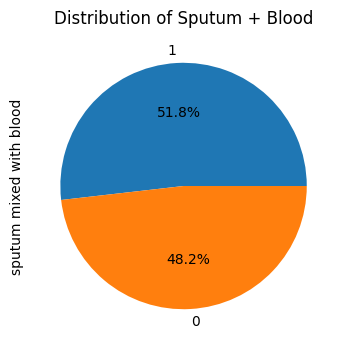

In [7]:
import matplotlib.pyplot as plt

# Plot the distribution of the binary column
plt.figure(figsize=(6, 4))
data['sputum mixed with blood'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Sputum + Blood')
plt.show()

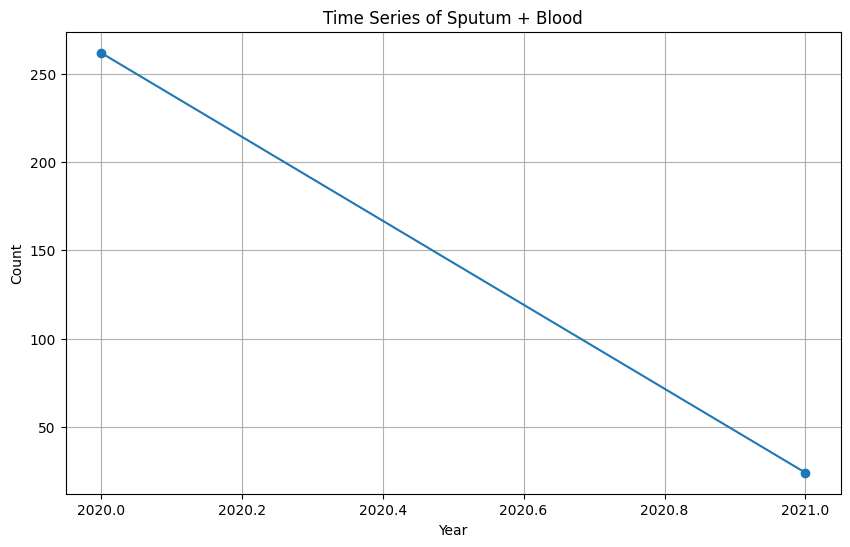

In [8]:
# Group data by year and count occurrences of "sputum mixed with blood"
yearly_counts = data.groupby(data['date'].dt.year)['sputum mixed with blood'].sum()

# Plot a time series of counts per year
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Time Series of Sputum + Blood')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Monthly Distribution of Sputum + Blood')

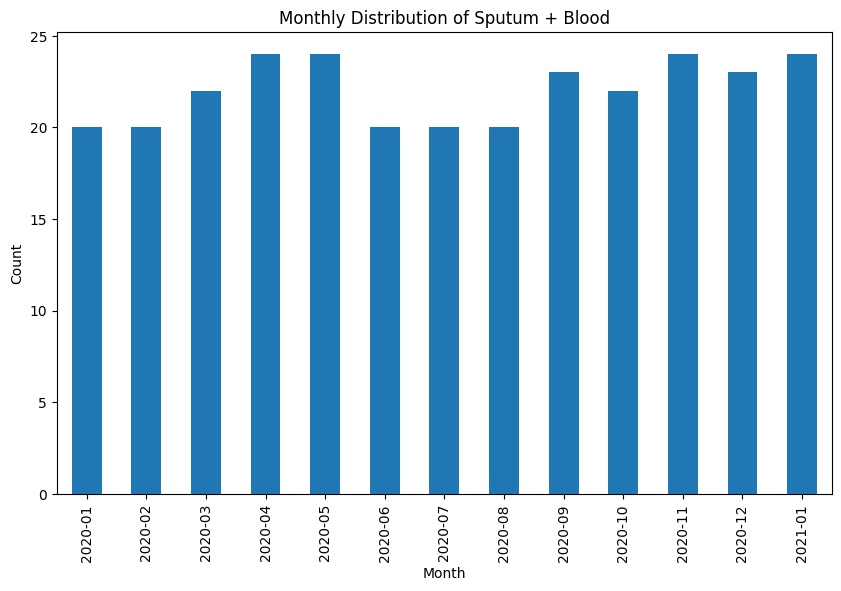

In [9]:
monthly_counts = data.groupby(data['date'].dt.to_period('M'))['sputum mixed with blood'].sum()
monthly_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Distribution of Sputum + Blood')

Text(0.5, 1.0, 'Heatmap of Sputum + Blood Over Time')

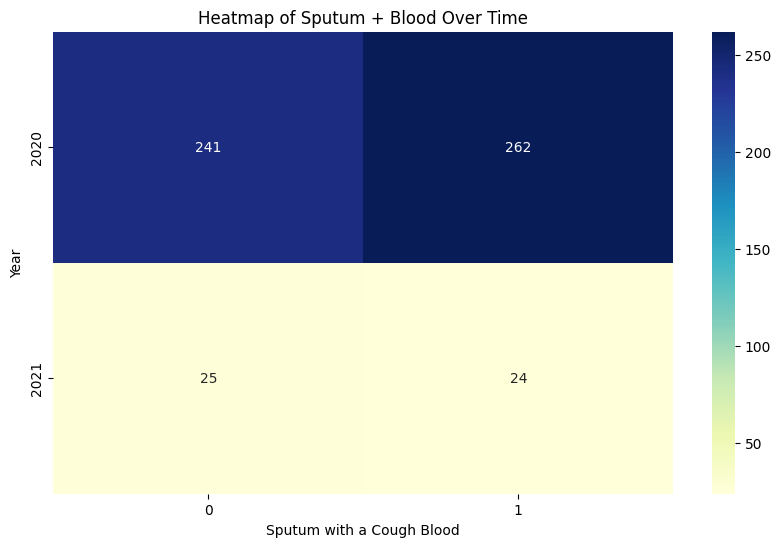

In [10]:
import seaborn as sns

crosstab = pd.crosstab(data['date'].dt.year, data['sputum mixed with blood'])
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Sputum with a Cough Blood')
plt.ylabel('Year')
plt.title('Heatmap of Sputum + Blood Over Time')

## GAN model designing and training

### Importing modules

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

### Designing the model

In [12]:
# Define a more comprehensive GAN architecture
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer

    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(512, input_dim=1))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer

    return model

# Build a comprehensive GAN
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = models.Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

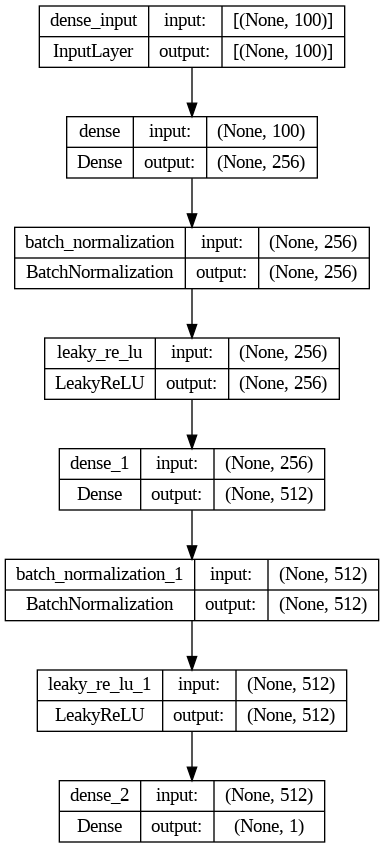

In [14]:
from keras.utils import plot_model

# Visualize the generator model
plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)

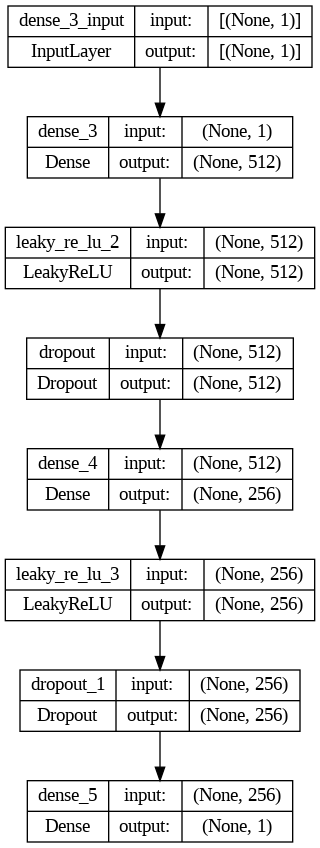

In [15]:
# Visualize the discriminator model
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True)

### Training the GAN

In [16]:
# Define GAN training loop
def train_gan(generator, discriminator, gan, real_data, latent_dim, epochs, batch_size):
  for epoch in range(epochs):
    for _ in range(real_data.shape[0] // batch_size):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        synthetic_data = generator.predict(noise)

        # Ensure the shape of synthetic_data matches that of real_data
        synthetic_data = synthetic_data.squeeze()  # Remove any extra dimensions

        # Create a mixed batch of real and synthetic data
        combined_data = np.concatenate((real_data[:batch_size], synthetic_data))
        combined_labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(combined_data, combined_labels)
        discriminator.trainable = False

        # Train the GAN
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_targets = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_targets)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Discriminator Loss: {d_loss}, GAN Loss: {g_loss}")

# Training the GAN
epochs = 1000
batch_size = 64
train_gan(generator, discriminator, gan, data['sputum mixed with blood'].values, latent_dim, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch 440, Discriminator Loss: 0.6955858469009399, GAN Loss: 0.7056988477706909
2/2 [==============================] - 0s 3ms/step
Epoch 440, Discriminator Loss: 0.6937474608421326, GAN Loss: 0.7579678297042847
2/2 [==============================] - 0s 4ms/step
Epoch 440, Discriminator Loss: 0.6873250007629395, GAN Loss: 0.713820219039917
2/2 [==============================] - 0s 4ms/step
Epoch 440, Discriminator Loss: 0.684367299079895, GAN Loss: 0.7286111116409302
2/2 [==============================] - 0s 4ms/step
Epoch 440, Discriminator Loss: 0.6902807950973511, GAN Loss: 0.7204447388648987
2/2 [==============================] - 0s 3ms/step
Epoch 440, Discriminator Loss: 0.6970977783203125, GAN Loss: 0.7276713848114014
2/2 [==============================] - 0s 4ms/step
Epoch 440, Discriminator Loss: 0.6809847950935364, GAN Loss: 0.6985799670219421
2/2 [=============================

### Generating synthetic data

In [17]:
def generate_synthetic_data(generator, num_samples, latent_dim=100):
    # Generate random noise for the generator
    noise = np.random.normal(0, 1, (num_samples, latent_dim))

    # Generate synthetic data using the generator
    synthetic_data = generator.predict(noise)

    return synthetic_data

# Generating synthetic data
num_samples = len(data)
synthetic_data = generate_synthetic_data(generator, num_samples)

18/18 [==============================] - 0s 2ms/step


## Concept drift detection and analysis

### Detection of concept drift

In [18]:
from statsmodels.stats.proportion import proportions_ztest

def detect_concept_drift(real_data, synthetic_data, significance_threshold):
    # Perform a two-sample proportion Z-test
    z_stat, p_value = proportions_ztest([real_data.sum(), synthetic_data.sum()],
                                        [len(real_data), len(synthetic_data)])

    if p_value < significance_threshold:
        return True  # Concept drift detected
    return False


# Detecting concept drift using a two-sample proportion Z-test
significance_threshold = 0.4

real_binary_data = data['sputum mixed with blood'].values
synthetic_binary_data = (synthetic_data > 0.5).astype(int).flatten()

concept_drift_detected = detect_concept_drift(real_binary_data, synthetic_binary_data, significance_threshold)
print("Concept Drift Detected:", concept_drift_detected)

Concept Drift Detected: True


### Time Series analysis of concept drift





**Z-Proportion (Z-Test for Proportions):**
Z-proportion is a statistical test used to compare proportions in two samples.
It is typically applied to binary or categorical data, where you want to assess whether the proportion of a specific outcome differs significantly between two groups.
The test calculates a Z-score and a p-value to determine whether the difference in proportions is statistically significant.
It's commonly used in A/B testing and concept drift detection to compare proportions of certain events or outcomes over time.

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1005: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1021: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)


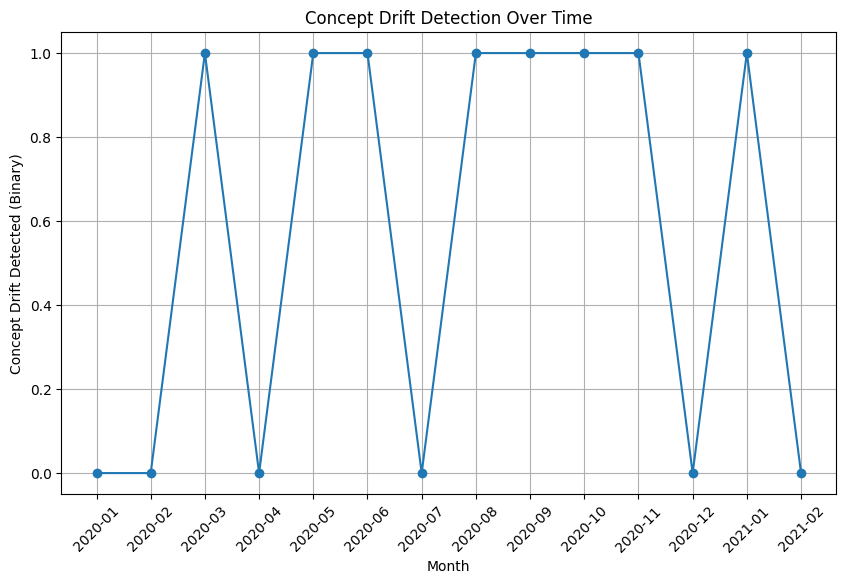

In [19]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

# Load your dataset and preprocess it as needed
data = pd.read_excel("Tb disease symptoms.xlsx")
data['date'] = pd.to_datetime(data['date'])

# Define the time periods for concept drift analysis
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-02-01')

# Initialize lists to store concept drift results and months
concept_drift_results = []
months = []

# Define a significance threshold for the two-sample proportion Z-test
significance_threshold = 0.4

# Loop through each month in the specified time range
current_date = start_date
while current_date <= end_date:
    # Filter data for the current month
    data_month = data[(data['date'] >= current_date) & (data['date'] < current_date + pd.DateOffset(months=1))]

    # Extract the binary data for the current month
    real_binary_data = data_month['sputum mixed with blood'].values

    # Perform a two-sample proportion Z-test with synthetic data (modify as needed)
    synthetic_binary_data = (synthetic_data > 0.5).astype(int).flatten()

    z_stat, p_value = proportions_ztest([real_binary_data.sum(), synthetic_binary_data.sum()],
                                        [len(real_binary_data), len(synthetic_binary_data)])

    # Append concept drift result and month to the lists
    concept_drift_results.append(p_value < significance_threshold)
    months.append(current_date.strftime("%Y-%m"))

    # Move to the next month
    current_date += pd.DateOffset(months=1)

# Visualize concept drift results over time
plt.figure(figsize=(10, 6))
plt.plot(months, concept_drift_results, marker='o', linestyle='-')
plt.title('Concept Drift Detection Over Time')
plt.xlabel('Month')
plt.ylabel('Concept Drift Detected (Binary)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Page-Hinkley Test (PHT):**
The Page-Hinkley Test is a statistical test used for detecting concept drift, particularly in streaming data.
It operates by monitoring a cumulative sum (CUSUM) of data over time and signals concept drift when the sum exceeds a predefined threshold.
The test is sensitive to sudden changes in the data distribution, making it suitable for real-time monitoring of data streams.
PHT is useful when you want to detect abrupt changes or shifts in the data distribution.

**Kullback-Leibler (KL) Divergence:**
KL Divergence, also known as relative entropy, is a measure of the difference between two probability distributions.
It quantifies how one probability distribution differs from a reference distribution.
In the context of concept drift, KL Divergence can be used to measure the dissimilarity between the data distribution at different time points.
A high KL Divergence suggests that the two distributions are significantly different, indicating potential concept drift.
It's particularly useful when you want to compare the evolution of data distributions over time.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


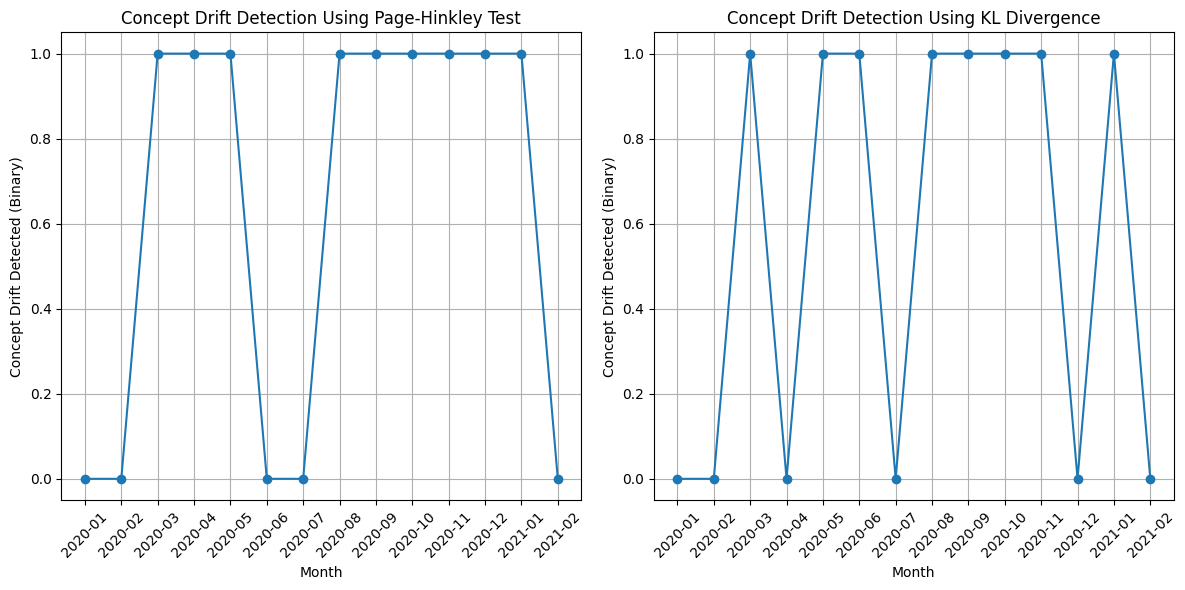

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load your dataset and preprocess it as needed
data = pd.read_excel("Tb disease symptoms.xlsx")
data['date'] = pd.to_datetime(data['date'])

# Define the time periods for concept drift analysis
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-02-01')

# Initialize lists to store concept drift results and months
concept_drift_results_page_hinkley = []
concept_drift_results_kl_divergence = []
months = []

# Loop through each month in the specified time range
current_date = start_date
while current_date <= end_date:
    # Filter data for the current month
    data_month = data[(data['date'] >= current_date) & (data['date'] < current_date + pd.DateOffset(months=1))]

    # Extract the binary data for the current month
    real_binary_data = data_month['sputum mixed with blood'].values

    # Calculate the statistic for Page-Hinkley test
    sum_diff = 0
    page_hinkley_statistic = []
    for value in real_binary_data:
        sum_diff = max(0, sum_diff + value - 0.1)  # You can adjust the lambda parameter
        page_hinkley_statistic.append(sum_diff)

    # Apply the Page-Hinkley test for concept drift detection
    concept_drift_results_page_hinkley.append(any(statistic > 30.0 for statistic in page_hinkley_statistic))  # You can adjust the threshold

    # Calculate the Kullback-Leibler Divergence
    synthetic_binary_data = (synthetic_data > 0.5).astype(int).flatten()
    kl_divergence = entropy(np.histogram(real_binary_data, bins=10, density=True)[0],
                            np.histogram(synthetic_binary_data, bins=10, density=True)[0])

    # Apply the Kullback-Leibler Divergence for concept drift detection
    concept_drift_results_kl_divergence.append(kl_divergence > 0.005)  # You can adjust the threshold

    months.append(current_date.strftime("%Y-%m"))

    # Move to the next month
    current_date += pd.DateOffset(months=1)

# Visualize concept drift results for Page-Hinkley test
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(months, concept_drift_results_page_hinkley, marker='o', linestyle='-')
plt.title('Concept Drift Detection Using Page-Hinkley Test')
plt.xlabel('Month')
plt.ylabel('Concept Drift Detected (Binary)')
plt.xticks(rotation=45)
plt.grid(True)

# Visualize concept drift results for Kullback-Leibler Divergence
plt.subplot(1, 2, 2)
plt.plot(months, concept_drift_results_kl_divergence, marker='o', linestyle='-')
plt.title('Concept Drift Detection Using KL Divergence')
plt.xlabel('Month')
plt.ylabel('Concept Drift Detected (Binary)')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

### Real VS Virtual Concept drift

**Real Concept Drift:**
The "Page-Hinkley Test" and "Kullback-Leibler Divergence (KL Divergence)" methods are used for detecting real concept drift.
The Page-Hinkley Test measures how the binary data's statistical characteristics change over time by accumulating the differences from a reference threshold. If this statistic exceeds a predefined threshold, it indicates the presence of concept drift.
The KL Divergence measures the dissimilarity between two probability distributions (real and synthetic data) and is used to detect changes in data distribution. If the calculated KL Divergence exceeds a certain threshold, it suggests concept drift.

**Virtual Concept Drift:**
The "Z-Test for Proportions" method is used for detecting virtual concept drift.
In this method, a two-sample proportion Z-test is performed on the real binary data and synthetic binary data. This test evaluates whether there is a statistically significant difference in proportions between these two datasets.
If the p-value from the Z-test is less than a predefined significance threshold (e.g., 0.4), it suggests that there is virtual concept drift. This means that the synthetic data, generated for comparison, differs significantly from the real data.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


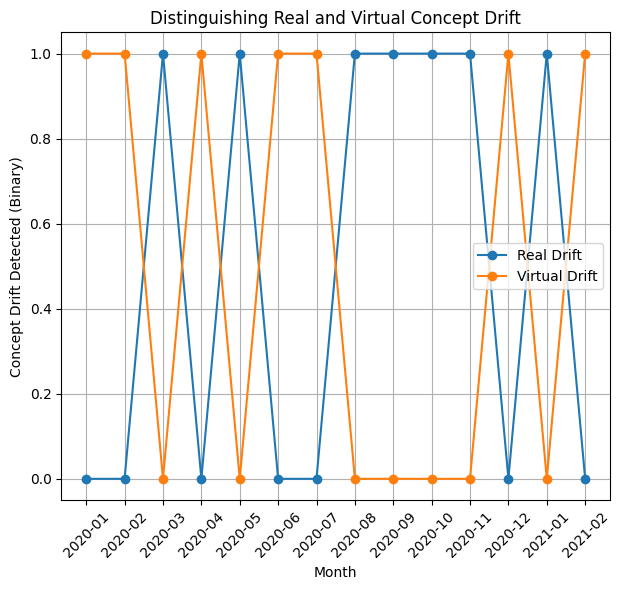

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load your dataset and preprocess it as needed
data = pd.read_excel("Tb disease symptoms.xlsx")
data['date'] = pd.to_datetime(data['date'])

# Define the time periods for concept drift analysis
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-02-01')

# Initialize lists to store concept drift results and months
concept_drift_results_page_hinkley = []
concept_drift_results_kl_divergence = []
months = []

# Initialize lists to distinguish real and virtual drift
real_drift = []
virtual_drift = []

# Loop through each month in the specified time range
current_date = start_date
while current_date <= end_date:
    # Filter data for the current month
    data_month = data[(data['date'] >= current_date) & (data['date'] < current_date + pd.DateOffset(months=1))]

    # Extract the binary data for the current month
    real_binary_data = data_month['sputum mixed with blood'].values

    # Calculate the statistic for Page-Hinkley test
    sum_diff = 0
    page_hinkley_statistic = []
    for value in real_binary_data:
        sum_diff = max(0, sum_diff + value - 0.1)  # You can adjust the lambda parameter
        page_hinkley_statistic.append(sum_diff)

    # Apply the Page-Hinkley test for concept drift detection
    page_hinkley_detected = any(statistic > 30.0 for statistic in page_hinkley_statistic)  # You can adjust the threshold

    # Calculate the Kullback-Leibler Divergence
    synthetic_binary_data = (synthetic_data > 0.5).astype(int).flatten()
    kl_divergence = entropy(np.histogram(real_binary_data, bins=10, density=True)[0],
                            np.histogram(synthetic_binary_data, bins=10, density=True)[0])

    # Apply the Kullback-Leibler Divergence for concept drift detection
    kl_divergence_detected = kl_divergence > 0.005  # You can adjust the threshold

    months.append(current_date.strftime("%Y-%m"))

    # Distinguish real and virtual concept drift
    if page_hinkley_detected and kl_divergence_detected:
        real_drift.append(True)
        virtual_drift.append(False)
    else:
        real_drift.append(False)
        virtual_drift.append(True)

    # Move to the next month
    current_date += pd.DateOffset(months=1)

# Visualize concept drift results and distinguish real and virtual drift
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(months, real_drift, marker='o', linestyle='-', label='Real Drift')
plt.plot(months, virtual_drift, marker='o', linestyle='-', label='Virtual Drift')
plt.title('Distinguishing Real and Virtual Concept Drift')
plt.xlabel('Month')
plt.ylabel('Concept Drift Detected (Binary)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1005: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1021: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)


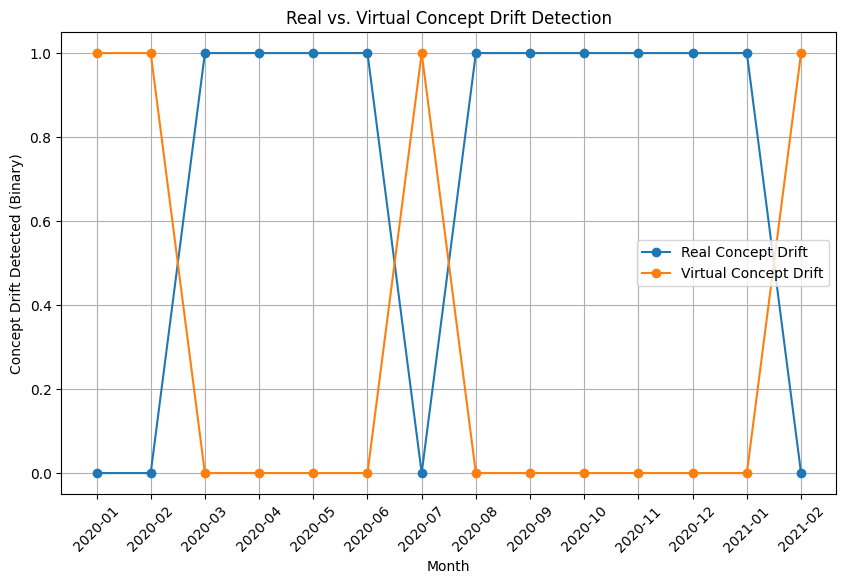

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from statsmodels.stats.proportion import proportions_ztest

# Load your dataset and preprocess it as needed
data = pd.read_excel("Tb disease symptoms.xlsx")
data['date'] = pd.to_datetime(data['date'])

# Define the time periods for concept drift analysis
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-02-01')

# Initialize lists to store concept drift results and months
concept_drift_results_pht = []
concept_drift_results_kl_divergence = []
concept_drift_results_z_test = []
real_concept_drift = []
virtual_concept_drift = []
months = []

# Loop through each month in the specified time range
current_date = start_date
while current_date <= end_date:
    # Filter data for the current month
    data_month = data[(data['date'] >= current_date) & (data['date'] < current_date + pd.DateOffset(months=1))]

    # Extract the binary data for the current month
    real_binary_data = data_month['sputum mixed with blood'].values

    # Calculate the statistic for Page-Hinkley test
    sum_diff = 0
    page_hinkley_statistic = []
    for value in real_binary_data:
        sum_diff = max(0, sum_diff + value - 0.1)  # You can adjust the lambda parameter
        page_hinkley_statistic.append(sum_diff)

    # Apply the Page-Hinkley test for concept drift detection
    concept_drift_results_pht.append(any(statistic > 30.0 for statistic in page_hinkley_statistic))  # You can adjust the threshold

    # Calculate the Kullback-Leibler Divergence
    synthetic_binary_data = (synthetic_data > 0.5).astype(int).flatten()
    kl_divergence = entropy(np.histogram(real_binary_data, bins=10, density=True)[0],
                            np.histogram(synthetic_binary_data, bins=10, density=True)[0])

    # Apply the Kullback-Leibler Divergence for concept drift detection
    concept_drift_results_kl_divergence.append(kl_divergence > 0.005)  # You can adjust the threshold

    # Perform a two-sample proportion Z-test with synthetic data (modify as needed)
    z_stat, p_value = proportions_ztest([real_binary_data.sum(), synthetic_binary_data.sum()],
                                         [len(real_binary_data), len(synthetic_binary_data)])

    # Append concept drift result and month to the list for Z-test
    concept_drift_results_z_test.append(p_value < 0.05)  # Adjust the significance level as needed

    # Distinguish real and virtual drift
    if any([concept_drift_results_pht[-1], concept_drift_results_kl_divergence[-1], concept_drift_results_z_test[-1]]):
        real_concept_drift.append(True)
        virtual_concept_drift.append(False)
    else:
        real_concept_drift.append(False)
        virtual_concept_drift.append(True)

    months.append(current_date.strftime("%Y-%m"))

    # Move to the next month
    current_date += pd.DateOffset(months=1)

# Visualize real and virtual concept drifts
plt.figure(figsize=(10, 6))
plt.plot(months, real_concept_drift, marker='o', linestyle='-', label='Real Concept Drift')
plt.plot(months, virtual_concept_drift, marker='o', linestyle='-', label='Virtual Concept Drift')
plt.title('Real vs. Virtual Concept Drift Detection')
plt.xlabel('Month')
plt.ylabel('Concept Drift Detected (Binary)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()